<a href="https://colab.research.google.com/github/aradhanacha/NLP/blob/master/LSTM_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import time
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter

Using TensorFlow backend.


In [29]:
data=pd.read_csv("/content/final_data.csv")
data.head()

,Unnamed: 0,Text,Mental_condition
0,1086997,but then again,0
1,859435,"Last full weekend in VA, heading back to TX ne...",0
2,1485762,away for a showrawrrrrr,0
3,1283538,@mamaspohr that story is adorable,0
4,1083484,@SpizzFlizz I'm 1day late or 2 thank you baby ...,0


# Labels
Mental_condition = 0   Not suicidal risk(no risk)
Mental_condition =1    depression
Mental_condition =2    suicide


In [27]:
#Define model paramater
TRAIN_SIZE=0.8
SEQUENCE_LENGTH=300
W2V_SIZE=300

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56065 entries, 0 to 56064
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        56065 non-null  int64 
 1   Text              55983 non-null  object
 2   Mental_condition  56065 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Preprocess dataset


In [32]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [34]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [35]:
%%time
data.Text = data.Text.apply(lambda x: preprocess(x))

CPU times: user 3.55 s, sys: 8.28 ms, total: 3.56 s
Wall time: 3.56 s


#split our dataset for train,test


In [36]:
df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 44852
TEST size: 11213


In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 40063


In [38]:
SEQUENCE_LENGTH=300

In [39]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Text), maxlen=SEQUENCE_LENGTH)

In [40]:
labels = df_train.Mental_condition.unique().tolist()
labels

[1, 0, 2]

In [41]:


y_train = pd.get_dummies(df_train['Mental_condition']).values
y_test = pd.get_dummies(df_test['Mental_condition']).values
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (11213, 3)


In [42]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (44852, 300)
y_train (44852, 3)

x_test (11213, 300)
y_test (11213, 3)


#Train model


In [43]:
model = Sequential()
model.add(Embedding(vocab_size, W2V_SIZE, input_length=SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          12018900  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 12,179,603
Trainable params: 12,179,603
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
epochs = 8
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 40366 samples, validate on 4486 samples
Epoch 1/8
40366/40366 [==============================] - 653s 16ms/step - loss: 0.1785 - accuracy: 0.9353 - val_loss: 0.1017 - val_accuracy: 0.9626
Epoch 2/8
40366/40366 [==============================] - 656s 16ms/step - loss: 0.0695 - accuracy: 0.9743 - val_loss: 0.1027 - val_accuracy: 0.9632
Epoch 3/8
40366/40366 [==============================] - 656s 16ms/step - loss: 0.0488 - accuracy: 0.9816 - val_loss: 0.1072 - val_accuracy: 0.9626
Epoch 4/8
40366/40366 [==============================] - 657s 16ms/step - loss: 0.0371 - accuracy: 0.9858 - val_loss: 0.1227 - val_accuracy: 0.9588


In [45]:
%%time
score = model.evaluate(x_test, y_test, batch_size=64)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

11213/11213 [==============================] - 37s 3ms/step

ACCURACY: 0.9648622274398804
LOSS: 0.10099654517350885
CPU times: user 59.5 s, sys: 4.11 s, total: 1min 3s
Wall time: 36.6 s


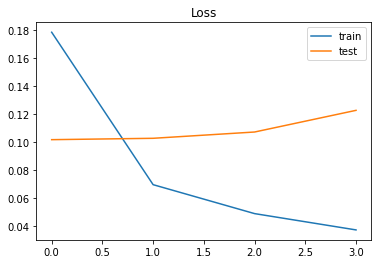

In [46]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [48]:
%time
y_pred_1d = []
y_test_1d = list(df_test.Mental_condition)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [np.argmax(score) for score in scores]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
11213/11213 [==============================] - 39s 3ms/step


Classification report


In [49]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3198
           1       0.96      0.97      0.97      4512
           2       0.97      0.94      0.95      3503

    accuracy                           0.96     11213
   macro avg       0.97      0.96      0.97     11213
weighted avg       0.96      0.96      0.96     11213



In [50]:
print(confusion_matrix(y_test_1d, y_pred_1d))

[[3130   34   34]
 [  39 4393   80]
 [  44  163 3296]]


#Inferance
The way I am categorising risk is 

  1.if predicted class is 0 risk is NOT_SUICIDAL
  2. if predicted class is 1(depression),based on prob score categorise it  into  mid risk or early sign
  3.If predicted class is 2(suicide) its already a high risk

In [51]:
THRESHOLDS = (0.6, 0.8)

In [52]:
def decode_risk(stage,score):  
  if stage==0:
    label = 'NOT_SUICIDAL'
  elif stage==1:
    if score >= THRESHOLDS[1]:
      label='MID_RISK'
    else:
      label='EARLY_SIGN'
  else:
    label='HIGH RISK'

  return label 

In [53]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_risk(np.argmax(score),np.max(score))

    return {"label": label, "score": max(score),
       "elapsed_time": time.time()-start_at}  

In [54]:
predict("I want to die")

{'elapsed_time': 0.027460813522338867,
 'label': 'HIGH RISK',
 'score': 0.7687432}

In [56]:
# EXPORT
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"
import pickle

In [57]:
model.save(KERAS_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)

#Predict few tweets


In [59]:
tweets=["I want to die","My life sucks","A am very angry","I am happy"," depression making me crazy"]
for text in tweets:
  print(predict(text))

{'label': 'HIGH RISK', 'score': 0.7687432, 'elapsed_time': 0.036821603775024414}
{'label': 'HIGH RISK', 'score': 0.50610083, 'elapsed_time': 0.02121257781982422}
{'label': 'NOT_SUICIDAL', 'score': 0.9801395, 'elapsed_time': 0.020761966705322266}
{'label': 'NOT_SUICIDAL', 'score': 0.8870919, 'elapsed_time': 0.020190954208374023}
{'label': 'MID_RISK', 'score': 0.9993222, 'elapsed_time': 0.020256996154785156}


#Lets see if we can load our model


In [60]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
new_m = load_model('model.h5')
# summarize model.
new_m.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          12018900  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 12,179,603
Trainable params: 12,179,603
Non-trainable params: 0
_________________________________________________________________


#Lets predict using our model on latest tweets


In [61]:
Pred_data=pd.read_csv("df_output.csv")
Pred_data.head()

,Unnamed: 0,User,Text,Retweets,Favorites,HashTags,City,date,time,month_year,text_nlp,text_len,word_count,polarity,sentiment,"people, life, change, die, virus, save, kill, normal, sick, action","thing, make, end, talk, person, quarantine, grow, win, reason, light","face, social, make, wear, weekend, mask, practice, distancing, distance, park","mind, bring, moment, create, full, thought, dream, power, experience, find","time, year, follow, post, hour, step, turn, ago, spend, provide","good, morning, fitness, daily, hit, yoga, member, early, live, wake","show, long, play, read, lol, line, picture, buy, fall, store","family, friend, positive, death, case, test, rise, state, number, black","check, night, watch, video, good, message, yesterday, full, late, youtube","work, give, hard, smile, happen, challenge, man, pay, beat, tough","day, happy, start, enjoy, beautiful, birthday, celebrate, week, movement, begin","training, ready, gym, find, train, online, woman, personal, top, fun","friend, listen, big, hand, game, lose, head, repost, shoot, awareness","world, place, put, remember, hope, lot, story, hear, forget, true","live, tonight, pm, join, meditation, share, music, word, favorite, tune","essential, support, care, worker, health, continue, fight, community, risk, business","order, free, call, open, food, sign, eye, studio, delivery, pick","love, great, guy, amazing, team, send, heart, job, nice, super","today, wait, book, link, bio, miss, session, tomorrow, visit, website","run, move, walk, eat, bad, easy, forward, mile, pretty, baby","feel, back, leave, important, double, energy, finally, tap, client, box","week, class, month, kid, virtual, join, dance, tomorrow, teach, photo","stop, learn, start, real, fear, part, close, break, school, share","set, exercise, minute, push, side, rest, leg, squat, schedule, info","stay, home, safe, healthy, fit, season, active, update, pray, inside","workout, body, strong, goal, high, focus, build, strength, add, level",0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,michaelbarata,New Blog Post: True Connection #love #connecti...,0,0,#love #connection #fear #lawofattraction,NY,2020-07-11,16:29:35,2020-07,new blog post true connection,34,5,0.243182,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,_TraceDollFace_,Oh a reunion heyyy #Alone,0,0,#Alone,NY,2020-07-11,19:43:21,2020-07,oh reunion heyyy,19,4,0.000000,neutral,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,sackec,Couldn’t be more accurate! The MLS will now ha...,0,0,#getoutofnyasfastasyoucan #sadness,NY,2020-07-01,12:42:16,2020-07,couldn t accurate mls new home listing thanks ...,139,24,0.245455,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,MamaAlboranista,#Repost goldenrulewill ・・・ via @lovewillam_ #R...,0,2,#Repost #Repost #suicideawarness #suicide #dep...,NY,2020-07-10,17:56:18,2020-07,goldenrulewill via lovewillam_ atrainlive make...,95,12,0.136364,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,Moosekj25,"Hey, so if Maxwell meets a premature end here .

In [62]:
%%time
Pred_data['Processed_Text'] = Pred_data.Text.apply(lambda x: preprocess(x))

CPU times: user 1.57 s, sys: 4.89 ms, total: 1.58 s
Wall time: 1.58 s


In [63]:
Pred_data.head()

,Unnamed: 0,User,Text,Retweets,Favorites,HashTags,City,date,time,month_year,text_nlp,text_len,word_count,polarity,sentiment,"people, life, change, die, virus, save, kill, normal, sick, action","thing, make, end, talk, person, quarantine, grow, win, reason, light","face, social, make, wear, weekend, mask, practice, distancing, distance, park","mind, bring, moment, create, full, thought, dream, power, experience, find","time, year, follow, post, hour, step, turn, ago, spend, provide","good, morning, fitness, daily, hit, yoga, member, early, live, wake","show, long, play, read, lol, line, picture, buy, fall, store","family, friend, positive, death, case, test, rise, state, number, black","check, night, watch, video, good, message, yesterday, full, late, youtube","work, give, hard, smile, happen, challenge, man, pay, beat, tough","day, happy, start, enjoy, beautiful, birthday, celebrate, week, movement, begin","training, ready, gym, find, train, online, woman, personal, top, fun","friend, listen, big, hand, game, lose, head, repost, shoot, awareness","world, place, put, remember, hope, lot, story, hear, forget, true","live, tonight, pm, join, meditation, share, music, word, favorite, tune","essential, support, care, worker, health, continue, fight, community, risk, business","order, free, call, open, food, sign, eye, studio, delivery, pick","love, great, guy, amazing, team, send, heart, job, nice, super","today, wait, book, link, bio, miss, session, tomorrow, visit, website","run, move, walk, eat, bad, easy, forward, mile, pretty, baby","feel, back, leave, important, double, energy, finally, tap, client, box","week, class, month, kid, virtual, join, dance, tomorrow, teach, photo","stop, learn, start, real, fear, part, close, break, school, share","set, exercise, minute, push, side, rest, leg, squat, schedule, info","stay, home, safe, healthy, fit, season, active, update, pray, inside","workout, body, strong, goal, high, focus, build, strength, add, level",0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Processed_Text
0,0,michaelbarata,New Blog Post: True Connection #love #connecti...,0,0,#love #connection #fear #lawofattraction,NY,2020-07-11,16:29:35,2020-07,new blog post true connection,34,5,0.243182,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,new blog post true connection love connection ...
1,0,_TraceDollFace_,Oh a reunion heyyy #Alone,0,0,#Alone,NY,2020-07-11,19:43:21,2020-07,oh reunion heyyy,19,4,0.000000,neutral,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,oh reunion heyyy alone
2,0,sackec,Couldn’t be more accurate! The MLS will now ha...,0,0,#getoutofnyasfastasyoucan #sadness,NY,2020-07-01,12:42:16,2020-07,couldn t accurate mls new home listing thanks ...,139,24,0.245455,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,accurate mls new home listing thanks thank tan...
3,0,MamaAlboranista,#Repost goldenrulewill ・・・ via @lovewillam_ #R...,0,2,#Repost #Repost #suicideawarness #suicide #dep...,NY,2020-07-10,17:56:18,2020-07,goldenrulewill via lovewillam_ atrainlive make...,95,12,0.136364,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0

In [64]:
#read_data
Pred_data['Mental_condition'] = Pred_data['Processed_Text'].apply(predict)

In [65]:
Pred_data.head()

,Unnamed: 0,User,Text,Retweets,Favorites,HashTags,City,date,time,month_year,text_nlp,text_len,word_count,polarity,sentiment,"people, life, change, die, virus, save, kill, normal, sick, action","thing, make, end, talk, person, quarantine, grow, win, reason, light","face, social, make, wear, weekend, mask, practice, distancing, distance, park","mind, bring, moment, create, full, thought, dream, power, experience, find","time, year, follow, post, hour, step, turn, ago, spend, provide","good, morning, fitness, daily, hit, yoga, member, early, live, wake","show, long, play, read, lol, line, picture, buy, fall, store","family, friend, positive, death, case, test, rise, state, number, black","check, night, watch, video, good, message, yesterday, full, late, youtube","work, give, hard, smile, happen, challenge, man, pay, beat, tough","day, happy, start, enjoy, beautiful, birthday, celebrate, week, movement, begin","training, ready, gym, find, train, online, woman, personal, top, fun","friend, listen, big, hand, game, lose, head, repost, shoot, awareness","world, place, put, remember, hope, lot, story, hear, forget, true","live, tonight, pm, join, meditation, share, music, word, favorite, tune","essential, support, care, worker, health, continue, fight, community, risk, business","order, free, call, open, food, sign, eye, studio, delivery, pick","love, great, guy, amazing, team, send, heart, job, nice, super","today, wait, book, link, bio, miss, session, tomorrow, visit, website","run, move, walk, eat, bad, easy, forward, mile, pretty, baby","feel, back, leave, important, double, energy, finally, tap, client, box","week, class, month, kid, virtual, join, dance, tomorrow, teach, photo","stop, learn, start, real, fear, part, close, break, school, share","set, exercise, minute, push, side, rest, leg, squat, schedule, info","stay, home, safe, healthy, fit, season, active, update, pray, inside","workout, body, strong, goal, high, focus, build, strength, add, level",0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Processed_Text,Mental_condition
0,0,michaelbarata,New Blog Post: True Connection #love #connecti...,0,0,#love #connection #fear #lawofattraction,NY,2020-07-11,16:29:35,2020-07,new blog post true connection,34,5,0.243182,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,new blog post true connection love connection ...,"{'label': 'NOT_SUICIDAL', 'score': 0.9583886, ..."
1,0,_TraceDollFace_,Oh a reunion heyyy #Alone,0,0,#Alone,NY,2020-07-11,19:43:21,2020-07,oh reunion heyyy,19,4,0.000000,neutral,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,oh reunion heyyy alone,"{'label': 'NOT_SUICIDAL', 'score': 0.9998105, ..."
2,0,sackec,Couldn’t be more accurate! The MLS will now ha...,0,0,#getoutofnyasfastasyoucan #sadness,NY,2020-07-01,12:42:16,2020-07,couldn t accurate mls new home listing thanks ...,139,24,0.245455,positive,0.035613,0.035613,0.035613,0.035613,0.054131,0.03767,0.035613,0.035613,0.035613,0.03767,0.035613,0.035613,0.035613,0.054131,0.035613,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0.052073,0.035613,0.035613,0.035613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,accurate mls new home listing thanks thank tan...,"{'label': 'NOT_SUICIDAL', 'score': 0.9977464, ..."
3,0,MamaAlboranista,#Repost goldenrulewill ・・・ via @lovewillam_ #R...,0,2,#Repost #Repost #suicideawarness #suicide #dep...,NY,2020-07-10,17:56:18,2020-07,goldenrulewill via lovewillam_ atrainlive make...,95,12,0.136364,positive,0.035613,0.035613,0.035613,0.0356

In [66]:
Pred_data.to_csv("Dashboard_Model_result.csv")